In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
!pip install pandas==2.2.3
!pip install tensorflow==2.17.1
!pip install pillow==11.1.0
!pip install matplotlib==3.9.2
!pip install transformers==4.38.2
!pip install torch

In [5]:
import zipfile
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import random

In [6]:
# Set seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Part 1: Classifying the Problem

#### 1.1 Dataset Preperation

In [7]:
#Set the batch size,epochs
batch_size = 32
n_epochs = 5
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)

In [11]:
import tarfile
import os
import shutil
import stat  # For changing file attributes

# Local file paths
filepath = r"C:\Users\Chris\OneDrive\IBM AI Engineering\Jupyter Notebooks\Course 2 Deep Learing and Neural Networks with Keras\dataset_url.txt"
tar_filepath = r"C:\Users\Chris\OneDrive - SNHU\IBM AI Engineering\Jupyter Notebooks\Course 2 Deep Learing and Neural Networks with Keras\aircraft_damage_dataset_v1.tar"
extracted_folder = "aircraft_damage_dataset_v1"  # Folder where contents will be extracted


def remove_readonly_and_delete(path):
    """Recursively removes the Read-only attribute and then deletes the directory/file."""
    try:
        if os.path.isdir(path):
            for root, dirs, files in os.walk(path):
                for d in dirs:
                    full_path = os.path.join(root, d)
                    os.chmod(full_path, stat.S_IWRITE)  # Remove Read-only attribute
                for f in files:
                    full_path = os.path.join(root, f)
                    os.chmod(full_path, stat.S_IWRITE)  # Remove Read-only attribute
            shutil.rmtree(path)  # Try deleting the directory
        elif os.path.exists(path):
            os.chmod(path, stat.S_IWRITE)  # Remove Read-only attribute
            os.remove(path)
    except Exception as e:
        print(f"Error deleting/modifying: {path} - {e}")


# Read the URL from the text file
with open(filepath, 'r') as file:
    url = file.read().strip()

# Check if the tar file exists locally
if not os.path.exists(tar_filepath):
    print(f"Error: Tar file not found at {tar_filepath}")
    exit()

print(f"Found tar file at {tar_filepath}. Extraction will begin now.")

# Check if the folder already exists and remove it safely
if os.path.exists(extracted_folder):
    print(f"The folder '{extracted_folder}' already exists. Removing it safely.")
    remove_readonly_and_delete(extracted_folder)
    print(f"Removed the existing folder: {extracted_folder}")

# Extract the contents of the tar file
try:
    with tarfile.open(tar_filepath, "r") as tar_ref:
        tar_ref.extractall()  # This will extract to the current directory
    print(f"Extracted {tar_filepath} successfully.")
except Exception as e:
    print(f"Error during extraction: {e}")

Found tar file at C:\Users\Chris\OneDrive - SNHU\IBM AI Engineering\Jupyter Notebooks\Course 2 Deep Learing and Neural Networks with Keras\aircraft_damage_dataset_v1.tar. Extraction will begin now.
The folder 'aircraft_damage_dataset_v1' already exists. Removing it safely.
Error deleting/modifying: aircraft_damage_dataset_v1 - [WinError 5] Access is denied: 'aircraft_damage_dataset_v1'
Removed the existing folder: aircraft_damage_dataset_v1
Error during extraction: [Errno 2] No such file or directory: '.\\aircraft_damage_dataset_v1\\train\\crack\\a0a6a9bd_342e_49c8_bb81_aff34c1884b4_f8fafc9e14d78d749effcce0bb27c750ae0bce11-1-_jpeg_jpg.rf.936568ae39225cedc41b43f638fca195.jpg'


In [12]:
# showing the content of the folder

import os

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

# Assuming 'extracted_folder' holds the name of the extracted dataset directory
extracted_folder = "aircraft_damage_dataset_v1"
print_directory_structure(extracted_folder)

aircraft_damage_dataset_v1/
    test/
        crack/
            101_1_JPG_jpg.rf.695bc0b3ba5ada38ee27d71dbacaf408.jpg
            103_6_JPG_jpg.rf.cbca4aacf826003ef682dc96f1dcbd4e.jpg
            104_16_JPG_jpg.rf.2c23b11777e1fbd5881eb06614f0d8b4.jpg
            105_22_JPG_jpg.rf.91531fce9d13ea5c9743426e43880986.jpg
            109_1_JPG_jpg.rf.e4846d98df8f2dbd7e98bad3c56e9bcb.jpg
            110_24_JPG_jpg.rf.5f5fb2963645a85c655c5492c0d5096a.jpg
            113_6_JPG_jpg.rf.c578c9850bdfe12f3941b0f53d35f419.jpg
            130_3_JPG_jpg.rf.cde17ae5dab82b38b9cd5634935e35d2.jpg
            130_7_JPG_jpg.rf.bc87b168142d43574d6b666d553f4761.jpg
            140_1_JPG_jpg.rf.783ec2a489ddc3692ef15efcb14436c6.jpg
            143_0_JPG_jpg.rf.6a95ea163581ec7c566872f750ee120e.jpg
            144_16_JPG_jpg.rf.547306a019ec79eae9c7ba648f0de46a.jpg
            145_4_JPG_jpg.rf.c24479fe868d62e5efe987e248c2b1af.jpg
            146_8_JPG_jpg.rf.e162c4a1747ab4f757124d7fe5b4d805.jpg
            147_21_

In [48]:
# Define directories for train, test, and validation splits
extract_path = "aircraft_damage_dataset_v1"
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')
valid_dir = os.path.join(extract_path, 'valid')


#### 1.2 Data Preprocessing

In [49]:
# Create ImageDataGenerators to preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [50]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),   # Resize images to the size VGG16 expects
    batch_size=batch_size,
    seed = seed_value,
    class_mode='binary',
    shuffle=True # Binary classification: dent vs crack
)

Found 141 images belonging to 1 classes.


## **Task 1: Create a `valid_generator` using the `valid_datagen` object**


Please use the following parameters:

*   **directory** should be set to `valid_dir`.
*   **class_mode** should be set to `'binary'`.
*   **seed** should be set to `seed_value`.
*   **batch_size** should be set to `batch_size`.
*   **shuffle** should be set to `False`.
*   **target_size** should be set to `(img_rows, img_cols)`.

Hint: the format should be like:

```python
valid_generator =  valid_datagen.flow_from_directory(
    directory=,
    class_mode=,
    seed=,
    batch_size=,
    shuffle=,
    target_size=
)
```

In [51]:
print(f"Valid directory path: {valid_dir}")

Valid directory path: aircraft_damage_dataset_v1\valid


In [52]:
valid_generator = valid_datagen.flow_from_directory(
    directory = valid_dir,
    class_mode = 'binary',
    seed = seed_value,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'aircraft_damage_dataset_v1\\valid'

## **Task 2: Create a `test_generator` using the `test_datagen` object**

Please use the following parameters:

*   **directory** should be set to `test_dir`.
*   **class_mode** should be set to `'binary'`.
*   **seed** should be set to `seed_value`.
*   **batch_size** should be set to `batch_size`.
*   **shuffle** should be set to `False`.
*   **target_size** should be set to `(img_rows, img_cols)`.

Hint: The format should be like:

```python
test_generator = test_datagen.flow_from_directory(
    directory=,
    class_mode=,
    seed=,
    batch_size=,
    shuffle=,
    target_size=
)
```

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory = test_dir,
    class_mode = 'binary',
    seed = seed_value,
    batch_size = batch_size,
    shuffle = False,
    target_size = (img_rows, img_cols)
)

## **Task 3: Load the pre-trained model VGG16**

Set <code>weights='imagenet'</code>,<code>include_top=False</code>,<code>input_shape=(img_rows, img_cols, 3)</code>

Hint: The format should be like:

base_model = VGG16(weights= , include_top= , input_shape=)

****Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission****

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
output = base_model.layers[-1].output
output = keras.layers.Flatten()(output)
base_model = Model(base_model.input, output)

# Freeze the base VGG16 model layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Build the custom model
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

## **Task 4: Compile the model**

You will compile the model using the following parameters:

*   **loss**: `'binary_crossentropy'`.
*   **optimizer**: `=Adam(learning_rate=0.0001)`.
*   **metrics**: `['accuracy']`.

Hint: Use `model.compile()` to compile the model:
    
```python
model.compile(
    optimizer=,
    loss=,
    metrics=
)
```
**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission.**


In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Task 5: Model Training
Now that the model is compiled, you can train it using the .fit() method. This step involves passing in the training and validation datasets along with the number of epochs you want to train the model for.

You will train the model using the following parameters:

*   **train_data**: `train_generator`
*   **epochs**: `n_epochs`
*   **validation_data**: `valid_generator`

Hint: Use `model.fit()` to train the model:
    
```python
history = model.fit(
    <train_data>,  # Fill in with the training data generator or dataset
    epochs=<number_of_epochs>,  # Fill in with the number of epochs for training
    validation_data=<validation_data>,  # Fill in with the validation data generator or dataset
   
)

```
**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission**


In [32]:
history = model

In [33]:
history.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=valid_generator,
)

AttributeError: 'BlipForConditionalGeneration' object has no attribute 'fit'

In [34]:
train_history = model.history.history

AttributeError: 'BlipForConditionalGeneration' object has no attribute 'history'

In [ ]:
# Plot the loss for both training and validation
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['loss'])
plt.show()

plt.title("Validation Loss")
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.plot(train_history['val_loss'])
plt.show()

## Task 6: Plot accuracy curves for training and validation sets

Hint: Similar to the loss curves. Use `plt.plot()` to plot the accuracy curves for training and validation sets.

- `figsize=(5, 5)`
- `plt.plot(train_history['accuracy'], label='Training Accuracy')`
- `plt.plot(train_history['val_accuracy'], label='Validation Accuracy')`
- **Title**: `'Accuracy Curve'`
- **xlabel**: `'Epochs'`
- **ylabel**: `'Accuracy'`

**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission**


In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Function to plot a single image and its prediction
def plot_image_with_title(image, model, true_label, predicted_label, class_names):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    # Convert labels from one-hot to class indices if needed, but for binary labels it's just 0 or 1
    true_label_name = class_names[true_label]  # Labels are already in class indices
    pred_label_name = class_names[predicted_label]  # Predictions are 0 or 1

    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis('off')
    plt.show()

# Function to test the model with images from the test set
def test_model_on_image(test_generator, model, index_to_plot=0):
    # Get a batch of images and labels from the test generator
    test_images, test_labels = next(test_generator)

    # Make predictions on the batch
    predictions = model.predict(test_images)

    # In binary classification, predictions are probabilities (float). Convert to binary (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # Get the class indices from the test generator and invert them to get class names
    class_indices = test_generator.class_indices
    class_names = {v: k for k, v in class_indices.items()}  # Invert the dictionary

    # Specify the image to display based on the index
    image_to_plot = test_images[index_to_plot]
    true_label = test_labels[index_to_plot]
    predicted_label = predicted_classes[index_to_plot]

    # Plot the selected image with its true and predicted labels
    plot_image_with_title(image=image_to_plot, model=model, true_label=true_label, predicted_label=predicted_label, class_names=class_names)




## **Task 7: Visualizing the results**

In this task, you will specify which image from the test dataset to display and test the model on. You will fill in the required values to test your model.

You will visualize using the following parameters:

*   **test_data_generator**: `test_generator`.
*   **model**: `model`.
*   **index_to_plot**: `1`.

Hint: Use `test_model_on_image` to visualize the result:
    
```python
test_model_on_image(<test_data_generator>, <model>, index_to_plot=index_to_plot)

```
**NOTE**: Due to the inherent nature of neural networks, predictions may vary from the actual labels. For instance, if the actual label is ‘crack’, the prediction could be either ‘crack’ or ‘dent’, both of which are possible outcomes, and full marks will be awarded for the task.

**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission**                                


In [30]:
index_to_plot = 1
test_model_on_image(test_generator, model, index_to_plot=index_to_plot)

NameError: name 'test_model_on_image' is not defined

## <a id='toc2_'></a>[Part 2: Image Captioning and Summarization using BLIP Pretrained Model](#toc2_)


BLIP (Bootstrapping Language-Image Pretraining) is an advanced vision-and-language model designed to generate natural language descriptions for images. By leveraging both visual and textual information, BLIP can produce human-readable text that accurately reflects the content and context of an image. It is specifically trained to understand images and their relationships to summarizing text, making it ideal for tasks like image captioning, summarization, and visual question answering.

In this project, learners will utilize the BLIP model to build a system capable of automatically generating captions and summary for images. The code will integrate the BLIP model within a custom Keras layer. This allows the user to input an image and specify a task, either "caption" or "summary", to receive a textual output that describes or summarizes the content of the image.


#### Key Steps:

- **Image Loading and Preprocessing:** The code will begin by loading images from a file path, then converting and processing them into a format suitable for input to the BLIP model.
  
- **Text Generation:** Depending on the task, whether generating a caption or summary, the BLIP model will generate corresponding text based on the processed image.
  
- **Custom Keras Layer:** A custom Keras layer is a user-defined layer that extends Keras' built-in functionality.Here custom Keras layer will be implemented to wrap the BLIP model. This layer will handle the task-specific processing (captioning or summarizing) and integrate smoothly into a TensorFlow/Keras environment.


In [22]:
#Load the required libraries
import torch
import tensorflow as tf
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

## 2.1 Loading BLIP Model

#### Load the BLIP Model and Processor from Hugging Face

Hugging Face is an open-source platform that provides pre-trained machine learning models, datasets, and tools, primarily focused on natural language processing, computer vision, and other AI tasks. It offers easy access to powerful models through its Transformers library.

- **BlipProcessor:** This handles the preprocessing of images and text. It converts images to the format that the BLIP model can understand.

- **BlipForConditionalGeneration:** This is the model itself, responsible for generating captions or summaries based on the processed image.



In [23]:
#load the pretrained BLIP processor and model:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

#### Custom Keras Layer: BlipCaptionSummaryLayer

Next, we define a custom `tf.keras.layers.Layer` class that takes in an image and a task input (either caption or summary) and processes the image using the BLIP model. To create a custom Keras layer, we need to subclass `tf.keras.layers.Layer` and implement the required methods.

#### **BlipCaptionSummaryLayer Class:**

This custom Keras layer integrates image preprocessing and text generation using a pretrained BLIP model.

- **`__init__`**: This constructor method initializes the `BlipCaptionSummaryLayer` class by setting up the BLIP processor and model.
  
- **`call`**: This method defines the operations or transformations applied to the input data as it passes through the layer.

- **`process_image`**: The `process_image` method contains the custom logic for loading the image, preprocessing it, generating the text (either a caption or a summary) using the BLIP model, and returning the generated result.


In [24]:
class BlipCaptionSummaryLayer(tf.keras.layers.Layer):
    def __init__(self, processor, model, **kwargs):
        """
        Initialize the custom Keras layer with the BLIP processor and model.

        Args:
            processor: The BLIP processor for preparing inputs for the model.
            model: The BLIP model for generating captions or summaries.
        """
        super().__init__(**kwargs)
        self.processor = processor
        self.model = model

    def call(self, image_path, task):
        # Use tf.py_function to run the custom image processing and text generation
        return tf.py_function(self.process_image, [image_path, task], tf.string)

    def process_image(self, image_path, task):
        """
        Perform image loading, preprocessing, and text generation.

        Args:
            image_path: Path to the image file as a string.
            task: The type of task ("caption" or "summary").

        Returns:
            The generated caption or summary as a string.
        """
        try:
            # Decode the image path from the TensorFlow tensor to a Python string
            image_path_str = image_path.numpy().decode("utf-8")

            # Open the image using PIL and convert it to RGB format
            image = Image.open(image_path_str).convert("RGB")

            # Set the appropriate prompt based on the task
            if task.numpy().decode("utf-8") == "caption":
                prompt = "This is a picture of"  # Modify prompt for more natural output
            else:
                prompt = "This is a detailed photo showing"  # Modify for summary

            # Prepare inputs for the BLIP model
            inputs = self.processor(images=image, text=prompt, return_tensors="pt")

            # Generate text output using the BLIP model
            output = self.model.generate(**inputs)

            # Decode the output into a readable string
            result = self.processor.decode(output[0], skip_special_tokens=True)
            return result
        except Exception as e:
            # Handle errors during image processing or text generation
            print(f"Error: {e}")
            return "Error processing image"


## Task 8: Implement a Helper Function to Use the Custom Keras Layer

In this task, you will implement a helper function `generate_text` that utilizes the custom `BlipCaptionSummaryLayer` Keras layer to generate captions or summaries for a given image. The function will accept an image path and a task type (caption or summary), process the image using the BLIP model, and return the generated text.

### **Steps:**

#### Create the Helper Function `generate_text`:
The function will accept following parameters:

* **`image_path`**: The path to the image file (in tensor format).
* **`task`**: The type of task to perform, which can either be "caption" or "summary" (in tensor format).
  
Inside the function:
1. Create an instance(blip_layer) of the `BlipCaptionSummaryLayer`.
2. Call this layer with the provided image path and task type.
3. Return the generated caption or summary as the output.

**Note: Please copy and save the code of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission**


In [25]:
def generate_text(image_path, task):
  blip_layer = BlipCaptionSummaryLayer(processor, model)
  generated_text = blip_layer(image_path, task)
  return generated_text

In [26]:

# Path to an example image
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/144_10_JPG_jpg.rf.4d008cc33e217c1606b76585469d626b.jpg")  # actual path of image

# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

# Generate a summary for the image
summary = generate_text(image_path, tf.constant("summary"))
# Decode and print the generated summary
print("Summary:", summary.numpy().decode("utf-8"))

Caption: this is a picture of a plane
Summary: this is a detailed photo showing the engine of a boeing 747


## Task 9: Generate a caption for an image using the using BLIP pretrained model

- Use the image_path variable given below to load the image. Run the cell to before proceeding to next step.
- Use the `generate_text` function to generate a caption for the image.
- Use the example given in `2.2 Generating Captions and Summaries` for this task
  
**Note:** Generated captions may not always be accurate, as the model is limited by its training data and may not fully understand new or specific images.
  
**Note: Please copy and save the output of the task as it will be required for submission in the final project. Ensure to submit the response as part of your project submission**


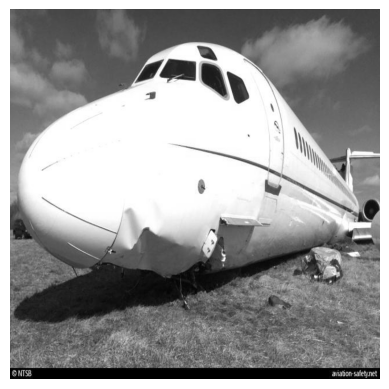

In [27]:
# We will use the following image to display Caption and Summary for Task 9 and 10
# URL of the image
image_url = "aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg"
# Load and display the image
img = plt.imread(image_url)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [28]:
image_path = tf.constant("aircraft_damage_dataset_v1/test/dent/149_22_JPG_jpg.rf.4899cbb6f4aad9588fa3811bb886c34d.jpg")  # actual path of image

In [29]:
# Generate a caption for the image
caption = generate_text(image_path, tf.constant("caption"))
# Decode and print the generated caption
print("Caption:", caption.numpy().decode("utf-8"))

Caption: this is a picture of a plane that was sitting on the ground in a field
